# Ecological Data Science for Sustainable Agriculture (Part IV)

In [18]:
# Vector processing
import geopandas as gpd
import shapely
import osgb

# Raster processing
import rasterio
import rasterio.warp
import rasterio.mask
import rasterio.plot
import rasterio.features
import rasterio.sample
from rasterio import windows
import pyproj
import xarray as xr
import rioxarray

# Calcs and modelling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
from matplotlib import pyplot as plt
import contextily as cx
import seaborn as sns

%matplotlib inline
mpl.rcParams['axes.formatter.limits'] = (0,0)
FIGSIZE = (10, 7)

# Practical
from glob import glob
import warnings
import os
from pystac_client import Client
import boto3
from dask.distributed import Client as DaskClient
from dask.distributed import print as distributed_print
import subprocess
import functools
import sys
sys.path.append('../../../../git_packages/PhenoloPy/scripts')
import phenolopy
from scipy.stats import pearsonr

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

DATA_BASE_PATH = '../../../data/Agric_data/' # all data under this path (global)



In [71]:
with rasterio.open(os.path.join(DATA_BASE_PATH, 'IYR/data/input_to_yield_ratio_honeybees.tiff')) as file:
    iyr_bees = file.read(1)
    iyr_nodata = file.profile['nodata']
    WORKING_CRS = file.crs
    extent = [file.bounds.left, file.bounds.right, file.bounds.bottom, file.bounds.top]
    

iyr_bees = np.where(iyr_bees == iyr_nodata, np.nan, iyr_bees)

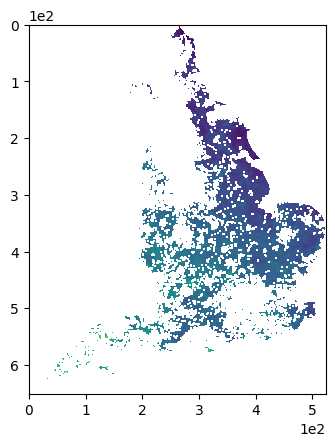

In [15]:


plt.figure()
plt.imshow(iyr_bees, interpolation=None)
plt.show()

In [81]:
sample_data = gpd.read_file(os.path.join(DATA_BASE_PATH, 'Pollinator_Fit_Counts/data/ukpoms_publicfitcountdata_2017-2020.csv' ), 
                             encoding='unicode_escape'
                           )

sample_data[['bumblebees',
'honeybees',
'solitary_bees',
'wasps',
'hoverflies',
'other_flies',
'butterflies_moths',
'beetles',
'insects_small',
'insects_other',
'all_insects_total']] = sample_data[['bumblebees',
'honeybees',
'solitary_bees',
'wasps',
'hoverflies',
'other_flies',
'butterflies_moths',
'beetles',
'insects_small',
'insects_other',
'all_insects_total']].astype(int)
sample_data['month'] = sample_data['date'].str.split('/').str[1]

In [82]:

def parse_grid_handle_error(x1km_ref):
    try:
        return osgb.gridder.parse_grid(x1km_ref)

    except:
        return None


def grid_to_ll_handle_error(grid_ref):
    try:
        return osgb.grid_to_ll(grid_ref)

    except:
        return (np.nan, np.nan)



sample_data['X1km_centre'] = sample_data['X1km_square'].str[:4].str.cat(sample_data['X1km_square'].str[4:], sep='5') + '5'

sample_data['geometry'] = sample_data['X1km_centre'].apply(parse_grid_handle_error).apply(grid_to_ll_handle_error).apply(lambda x: (x[1], x[0])).apply(shapely.geometry.Point)



In [90]:
sample_data = sample_data[~sample_data['geometry'].is_empty]
sample_data.set_crs('EPSG:4326', inplace=True).to_crs(WORKING_CRS, inplace=True)

In [84]:
extent

[132000.0, 656000.0, 6000.0, 658000.0]

In [85]:
WORKING_CRS

CRS.from_epsg(27700)

In [94]:
%matplotlib widget

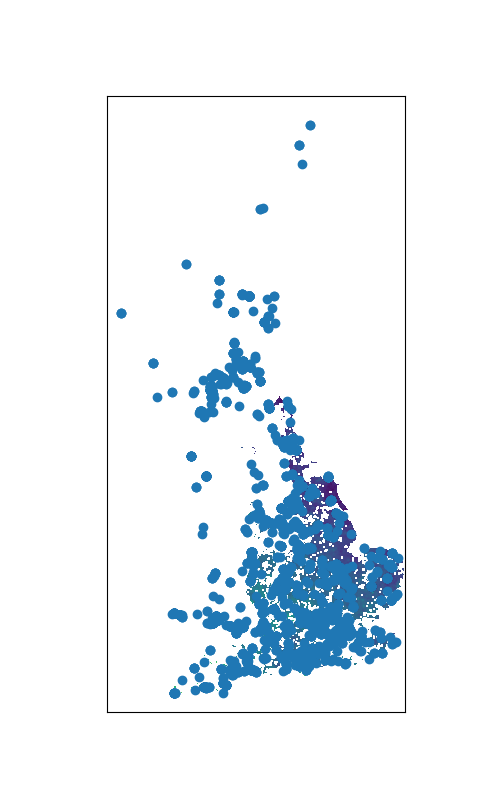

In [95]:


fig, ax= plt.subplots(figsize=(5, 8))

ax.imshow(iyr_bees, interpolation=None, extent=extent)
sample_data.plot(ax=ax, )

ax.set_xticks([])
ax.set_yticks([])
plt.show()

honeybees    Axes(0.125,0.11;0.775x0.77)
dtype: object

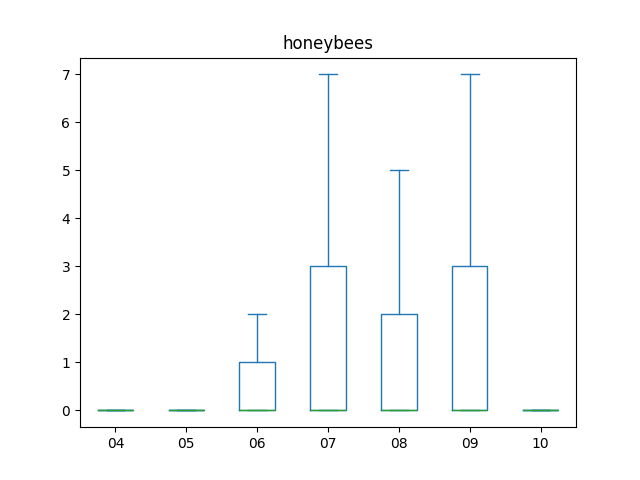

In [117]:
sample_data.plot.box(column='honeybees', by='month', sym='')

In [118]:
sample_data



,sample_id,country,date,year,X1km_square,sample_projection,digitised_by,recorder_type,habitat,habitat_other_detail,target_flower,target_flower_corrected,target_other_name,target_other_name_corrected,target_flower_family,flower_cover,floral_unit_count,floral_unit,flower_context,count_start_time,cloud_cover,sunshine,wind_speed,enjoyment,difficulty,habitat_type,flower_structure,bumblebees,honeybees,solitary_bees,wasps,hoverflies,other_flies,butterflies_moths,beetles,insects_small,insects_other,all_insects_total,geometry,X1km_centre,month
0,3501506,England,05/05/2018,2018,SK3648,OSGB,86644,I am familiar with recognising the main groups...,Garden,NA,Dandelion - Taraxacum officinale,Dandelion - Taraxacum officinale,NA,NA,Asteraceae,Target flowers cover less than half of patch,6,flower head,Growing in a larger patch of the same flower,11:55,All or mostly blue,Entirely in sunshine,Leaves moving gently all the time,Fun,Very easy,garden,open,0,0,0,0,0,0,0,0,0,0,0,POINT (436500.084 348502.088),SK365485,05
1,3493125,England,05/05/2018,2018,SK9482,OSGB,154133,I am familiar with identifying some wildlife g...,Garden,NA,Hawthorn - Crataegus,Hawthorn - Crataegus,NA,NA,Rosaceae,Target flowers cover about half of patch,22,individual flower,Growing in a larger patch of the same flower,15:01,All or mostly blue,Entirely in sunshine,Leaves moving gently all the time,Really fun!,Okay,garden,open,0,0,0,0,0,2,0,0,0,0,2,POINT (494499.828 382502.407),SK945825,05
2,3455170,England,05/05/2018,2018,SP0380,OSGB,73313,I am familiar with recognising the main groups...,Garden,NA,Other - please describe below,Other - please describe below,Pulmonaria,Pulmonaria,Boraginaceae,Target flowers cover about half of patch,15,individual flower,Growing in a larger patch of many different fl...,15:47,All or mostly blue,Partly in sun and partly shaded,Leaves still/moving occasionally,Okay,Easy,garden,closed,0,0,0,0,0,0,0,0,0,0,0,POINT (403500.416 280501.592),SP035805,05
3,3455025,England,05/05/2018,2018,ST3109,OSGB,156295,I am familiar with recognising the main groups...,Grassland with wild flowers (e.g. meadow),NA,Buttercup (Ranunculus species),Buttercup (Ranunculus species),NA,NA,Ranunculaceae,Target flowers cover less than half of patch,10,individual flower,Growing in a larger patch of the same flower,14:36,Half blue and half cloud,Entirely in sunshine,Leaves moving gently all the time,NA,NA,semi-natural,open,0,0,0,0,0,3,0,0,0,0,3,POINT (331499.557 109499.046),ST315095,05
4,3501609,England,19/05/2018,2018,SK3648,OSGB,86644,I am familiar with recognising the main groups...,Garden,NA,Dandelion - Taraxacum officinale,Dandelion - Taraxacum officinale,NA,NA,Asteraceae,Target flowers cover less than half of patch,1,flower head,More or less isolated,12:18,Half blue and half cloud,Entirely in sunshine,Leaves still/moving occasionally,Fun,Very easy,garden,open,0,0,0,0,0,0,0,0,0,0,0,POINT (436500.084 348502.088),SK365485,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3348,5619475,England,04/05/2019,2019,SK3648,OSGB,86644,I am familiar with recognising the main groups...,Garden,NA,Dandelion - Taraxacum officinale,Dandelion - Taraxacum officinale,NA,NA,Asteraceae,Target flowers cover less than half of patch,4,flower head,Growing in a larger patch of the same flower,15:23,Half blue and half cloud,Partly in sun and partly shaded,Leaves still/moving occasionally,Fun,Easy,garden,open,0,0,0,0,0,0,0,0,0,0,0,POINT (436500.084 348502.088),SK365485,05
3349,5600657,England,22/04/2019,2019,SK3584,OSGB,202018,I am confident in identifying the commonly-occ...,Garden,NA,Dandelion - Taraxacum officinale,Dandelion - Taraxacum officinale,NA,NA,Asteraceae,Target flowers cover less than half of patch,14,flower head,Growing in a larger patch of many different fl...,12:42,All or mostly blue,Partly in sun and partly shaded,Leaves moving gently all the time,Okay,Very easy,garden,open

In [120]:
# Build an SDM based on sample data (taking into account the various categorical factors, properly encoded)
# Compare against IYR and identify hotspots - areas where there are high biodiversity metrics and also a high ratio of pesticide/yield 

In [121]:
# Read this:

# https://nsojournals.onlinelibrary.wiley.com/doi/epdf/10.1111/ecog.05694

In [122]:
# Get relevant layers for UK covariates and whack together an SDM workflow